# Single-field two-phase momentum convection discretization 

There seems to be an error in the discretization or pressure-velocity coupling for the momentum convection term, namely 

$$\partial(\rho\mathbf{v}) + \nabla\cdot(\rho\mathbf{v}\mathbf{v}) = -\nabla p$$

$$\mathbf{v}(x,t_0) = (u, 0, 0)$$ 

$$p(x, t_0) = 0$$

Solving the momentum convection equation should result in a rate of change of the barycentric velocity that is equal to the ratio of the new momentum in the cell and the new mass for the multimaterial cell. 

The equation is discretized using unstructured collocated FVM using Rhie-Chow interpolation of the velocity in the pressure equation.  

![FVM discretization of the momentum convection equation](figures/OPENFOAM-MOMENTUM-CONVECTION-01.JPG)


# Symbolic FVM discretization in Sympy

The momentum equation discretized in the figure above is written symbolically using sympy

In [1]:
from sympy import * 
import numpy as np
import sympy
sympy.init_printing(use_latex='png', fontsize='12pt')

rho, rho1, rho2 = symbols(r"\rho \rho_1 \rho_2")
h = symbols("h")
S,V,dt = symbols(r"S V \Delta_t") 
U0 = 1 #symbols("U_0")
Uan0,Ubn0,Ucn0,Uwn0,Uen0 = symbols("u_a^{n} u_b^{n} u_c^{n} u_w^{n} u_e^{n}")
Uan1,Ubn1,Ucn1,Uwn1,Uen1 = symbols("u_a^{n+1} u_b^{n+1} u_c^{n+1} u_w^{n+1} u_e^{n+1}")
rhoan0,rhobn0,rhocn0,rhown0,rhoen0 = symbols(r"\rho_a^{n} \rho_b^{n} \rho_c^{n} \rho_w^{n} \rho_e^{n}")
rhoan1,rhobn1,rhocn1,rhown1,rhoen1 = symbols(r"\rho_a^{n+1} \rho_b^{n+1} \rho_c^{n+1} \rho_w^{n+1} \rho_e^{n+1}")

alpha = symbols(r"\alpha")

# Momentum equation with the linearized convective term and explicit discretization.
Ueqn = (V / dt)*(rhobn1*Ubn1 - rhobn0*Ubn0) - Uwn0*S*rhown0*Uwn0 + Uen0*S*rhoen0*Uen0
Ueqn

# Solving discretized momentum equation for $U_b^{n+1}$
 
To compute the new velocity $U_b^{n+1}$, we need an explicit discretization, and we assume $\Delta_t < \Delta_t^E$, where $\Delta_t^E$ provides a stable solution. 

Using Euler-explicit or Euler-implicit makes no difference in terms of the temporal order of accuracy, and the explicit discretization allows us to express the new velocity $U_b^{n+1}$ without having to solve a linear equationi system, i.e.

In [2]:
Ubn1Sol = solve(Ueqn, Ubn1)[0]

Ubn1Sol

The equation above reads: the change of the **momentum** via the inflow/outflow in the cell $b$ through the faces with area $S$ over the time step $\Delta_t$, plus the previous **momentum** in the cell, divided by the new **mass** in the cell $b$ is equal to the new **velocity** in the cell $b$.


# Assign a constant initial velocity and use equidistant cells

In [3]:
U0 = symbols("U0")
Ubn1SolExplicit = simplify(Ubn1Sol.subs({Uen0 : U0, Uwn0 : U0, Ubn0 : U0,  V : h**3, S : h**2}))
Ubn1SolExplicit

The new velocity still depends on the position of the interface, because the position of the interface determines the densities $\rho_b^n,\rho_b^{n+1},\rho_e^{n},\rho_w^{n}$.

# Use different positions of the interface 

Now we can take a look at different positions of the interface in the cell stencil $(a,b,c)$. 

## Interface position

Because $U(x,t) = (u,0,0)$, the position of the interface is

$$x_\Gamma(t) = x_\Gamma(t_0) + u\cdot t$$

## Interface orientation

Interface is oriented in the direction of the x-axis, 

$$n_\Gamma = (1,0,0).$$

and the phase indicator is defined as  

$$H(x, t) = \begin{cases}
    1 \quad \text{ if }  (x - x_\Gamma)\cdot n_\Gamma := \phi(x,x_\Gamma,n_\Gamma) > 0,  \\
    0 \quad \text{ if }  (x - x_\Gamma)\cdot n_\Gamma := \phi(x,x_\Gamma,n_\Gamma) < 0.
    \end{cases}$$

and the volume fraction is 

$$\alpha_V(t) := \dfrac{1}{V} \int_{V} H(x, t) dV$$

## Density model

$$\rho = \alpha \rho_1 + (1 - \alpha) \rho_2$$

With translation usign $U_0$ constant velocity in 1D, the volume fraction is simply 

$$\alpha_c(t + \Delta_t) = \alpha^n_c + \frac{\Delta_t  u_0  S} {V_c}$$

## Case A: Single phase cell 

All densities are the same for this cell 

In [4]:
Ubn1SolExplicitA = Ubn1SolExplicit.subs({rhown0 : rho1, rhobn0 : rho1, rhobn1 : rho1, rhoen0 : rho1})
Ubn1SolExplicitA

Velocity of the cell doesn't change for single-phase cells: the initial pressure gradient $\nabla p =  0$ because $p(x, t_0) = 0$, and with constant density, and velocity initial and boundary conditions, this is expected. Momentum is conserved for the trivial case of a single-phase flow without pressure gradient and with a constant velocity and there is no need for pressure-velocity coupling to ensure divergence free velocity field. 

## Case B: interface stays between $[x_w, x_b]$ 

$$\Large----a-----w-|_{\Gamma^{n}}-b----e----c----$$

$$\Large----a-----w--|_{\Gamma^{n+1}}b----e----c----$$

$|_\Gamma$ denotes the position of the Front $\Gamma$ at time $t$ in the cell stencil (a,b,c).

This sets the negative distance field $^-$ and positive distance field values $^+$ at $n,n+1$ as follows

$$\Large----a^{-}----w^{-}----b^+----e^+----c^+----$$

From the signs of the signed distance function $\phi$ in the above stencil, which is for this case the same for $n,n+1$, we see that 

$$\rho_w^{n} = \rho_2$$ 

$$\rho_b^{n} = \rho_1$$

$$\rho_b^{n+1} = \rho_1$$

$$\rho_e^{n} = \rho_1$$

Which we substitute into the solution for $U_b^{n+1}$

In [5]:
Ubn1SolExplicitB = Ubn1SolExplicit.subs({rhown0 : rho2, rhobn0 : rho1, rhobn1 : rho1, rhoen0 : rho1})
Ubn1SolExplicitB

Obviously there is a change in the cell velocity, that will somehow depend on $\rho_1/\rho_2$, lets use $\rho_1 = 1000 \rho_2$ (air bubble in water)

In [6]:
Ubn1SolExplicitBwaterAir = simplify(Ubn1SolExplicitA.subs({rho1 : 1000 * rho2}))
Ubn1SolExplicitBwaterAir

Alternatively, 

$$U_b^{n+1} = U_0 - U_0\dfrac{999CFL}{1000}$$

Unless $CFL = 1000 / 999$, the velocity drops in this cell. Considering again case A, cells $a$ and $c$ are both single-phase cells, for which the velocity doesn't change. This means that the velocity field $U_a^{n+1}= U_c^{n+1} \ne U_b^{n+1}$ **is still divergence free in the discrete sense**.



## Case C : interface crossed cell center $b$ 

$$\Large----a-----w-|_{\Gamma^{n}}-b----e----c---$$
$$\Large----a-----w---b-|_{\Gamma^{n+1}}---e----c---$$
\end{align*}

$|_\Gamma$ denotes the position of the Front $\Gamma$ at time $t$ in the cell stencil (a,b,c).

This sets the negative distance field $^-$ and positive distance field values $^+$ at $n,n+1$ as follows

\begin{align*}
\Large
&\Large----a^{-}----w^{-}----b^+----e^+----c^+----\\
&\Large----a^{-}----w^{-}----b^-----e^+----c^+----
\end{align*}

From the signs of the signed distance function $\phi$ in the above stencil, which is for this case the same for $n,n+1$, we see that 

\begin{align}
\rho_w^{n} = \rho_2 \\
\rho_b^{n} = \rho_1 \\
\rho_b^{n+1} = \rho_2 \\
\rho_e^{n} = \rho_1 
\end{align}

Which we substitute into the solution for $U_b^{n+1}$

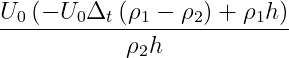

In [7]:
Ubn1SolExplicitC = Ubn1SolExplicit.subs({rhown0 : rho2, rhobn0 : rho1, rhobn1 : rho2, rhoen0 : rho1})
Ubn1SolExplicitC

Compared with **case B**

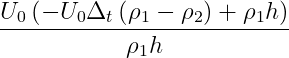

In [8]:
Ubn1SolExplicitB

Water / air density ratio

In [9]:
Ubn1SolExplicitCwaterAir = simplify(Ubn1SolExplicitC.subs({rho1 : 1000 * rho2}))
Ubn1SolExplicitCwaterAir

# Case D : interface stays between $[x_b,x_e]$

$$\Large----a-----w---b-|_{\Gamma^{n}}---e----c----$$
$$\Large----a-----w--b----|_{\Gamma^{n+1}}e----c----$$

$\Gamma$ denotes the position of the Front $\Gamma$ at time $t$ in the cell stencil (a,b,c).

This sets the negative distance field $^-$ and positive distance field values $^+$ at $n,n+1$ as follows

$$\Large----a^{-}----w^{-}----b^-----e^+----c^+----$$

From the signs of the signed distance function $\phi$ in the above stencil, which is for this case the same for $n,n+1$, we see that 

$$\rho_w^{n} = \rho_2$$ 

$$\rho_b^{n} = \rho_2$$ 

$$\rho_b^{n+1} = \rho_2$$ 

$$\rho_e^{n} = \rho_1$$ 

Which we substitute into the solution for $U_b^{n+1}$

In [10]:
Ubn1SolExplicitD = Ubn1SolExplicit.subs({rhown0 : rho2, rhobn0 : rho2, rhobn1 : rho2, rhoen0 : rho1})
Ubn1SolExplicitD

Comparing with other multiphase cell cases

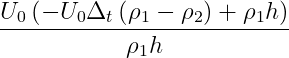

In [11]:
Ubn1SolExplicitB

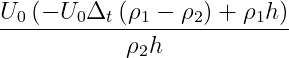

In [12]:
Ubn1SolExplicitC

Water/air density ratio

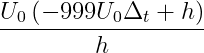

In [13]:
Ubn1SolExplicitDwaterAir = simplify(Ubn1SolExplicitD.subs({rho1 : 1000 * rho2}))
Ubn1SolExplicitDwaterAir

# Case E : interface leaves the cell 

$$\Large----a-----w--b----|_{\Gamma^{n}}e----c----$$ 

$$\Large----a-----w--b----e-|_{\Gamma^{n+1}}----c----$$ 


$\Gamma$ denotes the position of the Front $\Gamma$ at time $t$ in the cell stencil (a,b,c).

This sets the negative distance field $^-$ and positive distance field values $^+$ at $n,n+1$ as follows


$$\Large----a^{-}----w^{-}----b^-----e^+----c^+----$$ 

$$\Large----a^{-}----w^{-}----b^-----e^-----c^+----$$


From the signs of the signed distance function $\phi$ in the above stencil, which is for this case the same for $n,n+1$, we see that 

$$\rho_w^{n} = \rho_2$$ 

$$\rho_b^{n} = \rho_2$$ 

$$\rho_b^{n+1} = \rho_2$$

$$\rho_e^{n} = \rho_1$$ 


Nothing changes with respect to case D with an explicit discretization.

# Conclusions

The cell velocity seems to change after the solution of the momentum equation only for multimaterial cells. 

The question remains if the pressure is affected.  

If we use a sharp marker field model, that only maintains $0 \le \alpha_c \le 1$ for a single layer of cells that are intersected with the Front $\Gamma$, we will have $U_a^{n+1} = U_c^{n+1} \ne U_b^{n+1}$.

However, this is still a discretely divergence-free velocity field, because $U_e^{n+1} = U_w^{n+1}$, if the same interpolation scheme is used for $e$ and $w$. 

Now, if

$$\nabla\cdot\frac{1}{ap}\nabla p = \nabla\cdot \frac{1}{a_p}H(U)$$ 

is discretized as  

$$\sum_{f\in F_c} \frac{1}{a_p}|_f\nabla p|_f \cdot \mathbf{S}_f = \sum_{f\in F_c} \frac{1}{a_p}|_fH(U)|_f\cdot \mathbf{S}_f$$

We need to check if 

$$\dfrac{1}{a_P}|_w \ne \dfrac{1}{a_P}|_e$$?

and

$$H(U)|_w \ne H(U)|_e$$? 

$H(U)$ is the explicit formula used for $U_b^{n+1}$ all over this notebook without the temporal term that is separated into the diagonal coefficient, and source term contribution. 

**Cells adjacent to multimaterial cells**

Consider the cell $c$ in the stencil, if cell $b$ is multimaterial. 

Those cells are going to have

$$\dfrac{1}{a_P}|_w \ne \dfrac{1}{a_P}|_e$$

and

$$H(U)|_w \ne H(U)|_e$$,

because the densities and velocities of their **east (right)** neighbors will be the same as theirs at $t^n$. 

That might be the reason why large accellerations are present in those cells, simply because the pressure equation has a source term active for those cell, that actually shouldn't be. 